In [1]:
# General Dependencies
import timeit, os
import numpy as np
import scipy.io as io

from denoise import temporal

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose

# Plot & Video Dependencies
import mpdf_plot
import matplotlib.pyplot as plt

# Plots
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import write_mpl, play_cv2

%load_ext autoreload
%autoreload 2

# Make Videowriting Function

In [2]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

def write_video(mov, title, filename, clip=[0,1], mov_width=24):
    
    d1, d2, num_frames = mov.shape
    
    # Find Figsize As To Almost Fit The Screen
    aspect_ratio = d1/d2
    mov_height = int(np.ceil(aspect_ratio * mov_width)) # account for cbar
    
    Yd_1 = (mov).transpose([2,0,1]);
    Yd_1 = Yd_1 - Yd_1.min(axis=0, keepdims=True);
    Yd_1 = (Yd_1 - Yd_1.min())/(Yd_1.max() - Yd_1.min());
    Yd_1 = np.clip(Yd_1, clip[0], clip[1]);
    Yd_1 = (Yd_1 - Yd_1.min())/(Yd_1.max() - Yd_1.min());

    fig = plt.figure(figsize=(mov_width,mov_height));
    ax1 = plt.subplot(1,1,1)
    ax1.set(title=title)
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.tight_layout()

    img1 = ax1.imshow(Yd_1[0,:,:],vmin=Yd_1.min(),vmax=Yd_1.max(),cmap="Greys_r");
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(img1, cax=cax,orientation='vertical',spacing='uniform')

    def update(i):
        img1.set_data(Yd_1[i+1,:,:]);
        ax1.set(title=title + " Frame: {}".format(i))
        return [img1]

    ani = animation.FuncAnimation(fig, update, frames=num_frames-1, blit=True);
    ani.save(filename, fps=60)

# Record System Info

In [3]:
!uname -a

Linux ubuntu-box 4.10.0-33-generic #37~16.04.1-Ubuntu SMP Fri Aug 11 14:07:24 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


In [4]:
!cpuinfo

Intel(R) processor family information utility, Version 2018 Update 2 Build 20180125 (id: 18157)
Copyright (C) 2005-2018 Intel Corporation.  All rights reserved.

=====  Processor composition  =====
Processor name    : Intel(R) Core(TM) i7-6850K  
Packages(sockets) : 1
Cores             : 6
Processors(CPUs)  : 12
Cores per package : 6
Threads per core  : 2

=====  Processor identification  =====
Processor	Thread Id.	Core Id.	Package Id.
0       	0   		0   		0   
1       	0   		1   		0   
2       	0   		2   		0   
3       	0   		3   		0   
4       	0   		4   		0   
5       	0   		5   		0   
6       	1   		0   		0   
7       	1   		1   		0   
8       	1   		2   		0   
9       	1   		3   		0   
10      	1   		4   		0   
11      	1   		5   		0   
=====  Placement on packages  =====
Package Id.	Core Id.	Processors
0   		0,1,2,3,4,5		(0,6)(1,7)(2,8)(3,9)(4,10)(5,11)

=====  Cache sharing  =====
Cache	Size		Processors
L1	32  KB		(0,6)(1,7)(2,8)(3,9)(4,10)(5,11)
L2	256 KB		(0,6)(1,7)(2,8)(3,9)(

# Set Parameters

In [5]:
dx=4
ext = "../trefide"

# Tolias 3P

In [6]:
# Set Data Information
dataset = "3P"
filename = os.path.join(ext, "data", "18252_5_00006_00001_trimmed_d2_v1_rig_10.npz")
block_height = 40
block_width = 28

In [7]:
mov = np.load(filename)['data'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [8]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

## Run Decomposition

In [9]:
# Perform 4x Overlapping Blockwise gPCA In Parallel
mov_denoised, block_ranks = temporal(
    mov.copy(), dx=dx, nblocks=[int(fov_height/block_height),
                                int(fov_width/block_width)])

Running 50 blocks in 10 cpus
Blocks(=50) run time: 5.955397
Running 40 blocks in 10 cpus
Blocks(=40) run time: 4.406861
Running 45 blocks in 10 cpus
Blocks(=45) run time: 5.404868
Running 36 blocks in 10 cpus
Blocks(=36) run time: 4.066808


## Run Timing Evaluation

In [10]:
def time_gPCA():
    gpca_denoised, gpca_ranks = temporal(mov,
                                         dx=1,
                                         nblocks=[int(fov_height/block_height),
                                                  int(fov_width/block_width)])

timeit.timeit(time_gPCA, number=5)/5

Running 50 blocks in 10 cpus
Blocks(=50) run time: 6.812204
Running 50 blocks in 10 cpus
Blocks(=50) run time: 7.015555
Running 50 blocks in 10 cpus
Blocks(=50) run time: 6.978779
Running 50 blocks in 10 cpus
Blocks(=50) run time: 6.887367
Running 50 blocks in 10 cpus
Blocks(=50) run time: 7.126777


8.436439682799392

## Postprocessing

In [11]:
# Crop Problematic Border
mov = mov[20:-20,20:-20,:]
mov_denoised = mov_denoised[20:-20,20:-20,:]

## Produce Performance Diagnostics

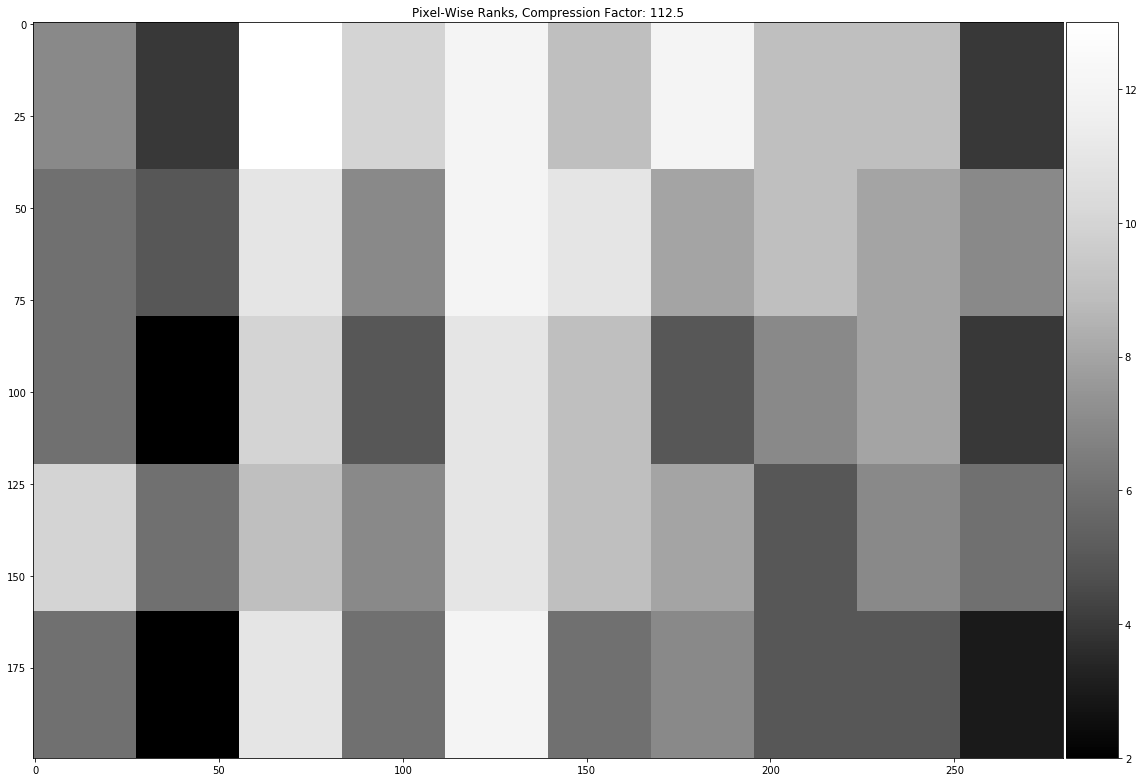

In [12]:
pixelwise_ranks(block_ranks[0], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [3.7e-02 2.3e-01]
Local correlation:  range [-2.8e-01 9.8e-01]
Local correlation:  range [1.9e-02 1.4e-01]


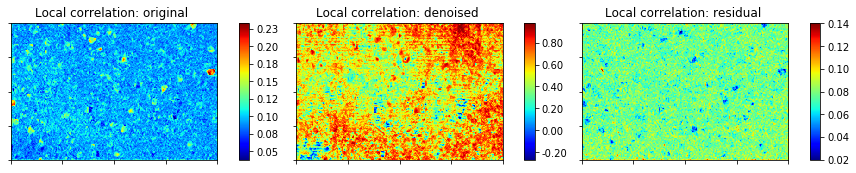

In [13]:
comparison_plot([mov, mov_denoised], plot_orientation="vertical")

## Generate Paper Figs

Frame:  range [-1.7e+00 7.7e+00]
Frame:  range [-1.8e+00 4.9e+00]
Frame:  range [-3.5e+00 7.5e+00]
SNR:  range [1.1e+00 1.4e+00]
SNR:  range [1.4e+00 4.5e+00]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [4.6e-02 2.1e-01]
Local correlation:  range [3.2e-02 1.4e-01]


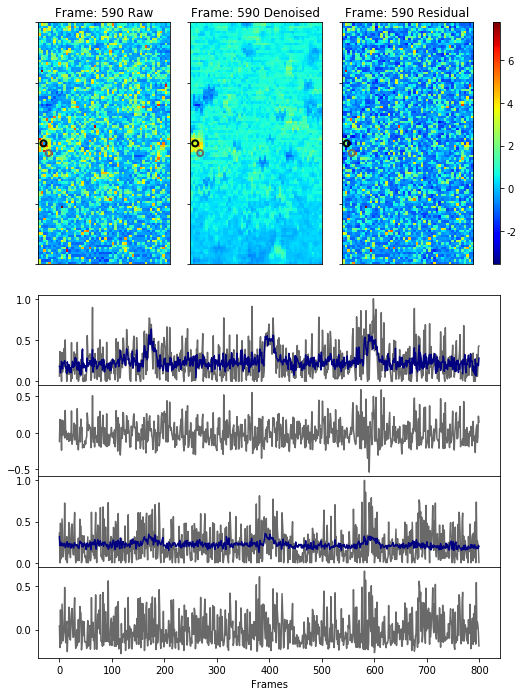

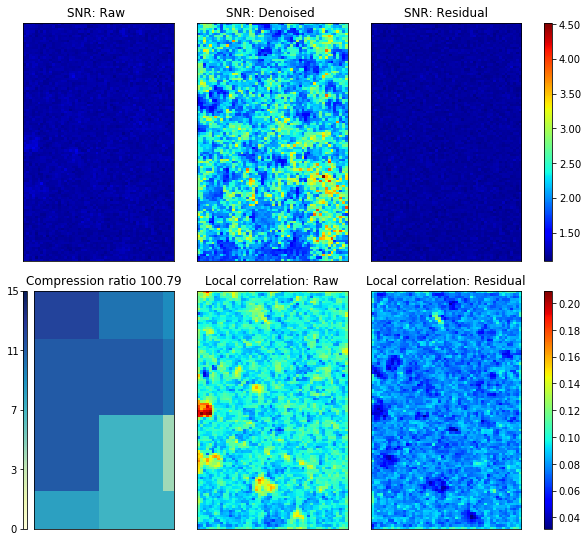

In [14]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks[0],
                    pixel_coor1=[94, 2],
                    pixel_coor2=[98, 4],
                    frame_idx=590,
                    trace_seg=[0, 800],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='3P_gPCA.pdf')
plt.show()

## Write Video

In [15]:
#write_video(np.hstack([mov, mov_denoised, mov - mov_denoised]),
#            "gPCA - Tolias 3P",
#            "3P_gPCA.mp4")
#plt.show()
np.savez(os.path.join(ext, "data", "3P_gPCA.npz"), mov, mov_denoised)

# Q-State Bio Voltage Imaging

In [16]:
# Set Data Information
dataset = "Voltage"
filename = os.path.join(ext, "data", "denoised_IE017.npz")
block_height = 40
block_width = 40

In [17]:
mov = np.load(filename)['arr_0'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Run Decomposition

In [18]:
# Perform 4x Overlapping Blockwise gPCA In Parallel
mov_denoised, block_ranks = temporal(
    mov.copy(), dx=dx, nblocks=[int(fov_height/block_height),
                                int(fov_width/block_width)])

Running 40 blocks in 10 cpus
Blocks(=40) run time: 15.822534
Running 20 blocks in 10 cpus
Blocks(=20) run time: 8.977184
Running 38 blocks in 10 cpus
Blocks(=38) run time: 16.329205
Running 19 blocks in 10 cpus
Blocks(=19) run time: 9.382048


## Run Timing Evaluation

In [19]:
def time_gPCA():
    gpca_denoised, gpca_ranks = temporal(mov,
                                         dx=1,
                                         nblocks=[int(fov_height/block_height),
                                                  int(fov_width/block_width)])

timeit.timeit(time_gPCA, number=5)/5

Running 40 blocks in 10 cpus
Blocks(=40) run time: 14.582281
Running 40 blocks in 10 cpus
Blocks(=40) run time: 14.506763
Running 40 blocks in 10 cpus
Blocks(=40) run time: 14.633429
Running 40 blocks in 10 cpus
Blocks(=40) run time: 14.422897
Running 40 blocks in 10 cpus
Blocks(=40) run time: 14.173656


17.459702512598597

## Produce Performance Diagnostics

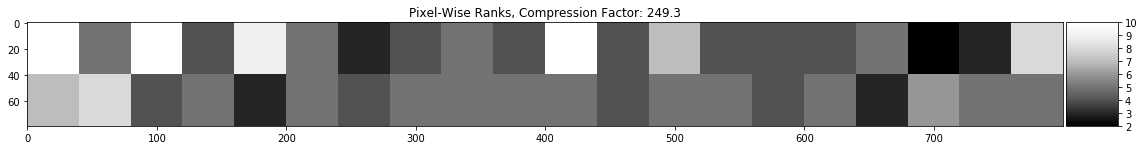

In [20]:
pixelwise_ranks(block_ranks[0],
                fov_height, fov_width,
                num_frames, block_height, block_width)

Local correlation:  range [-1.9e-02 8.6e-01]
Local correlation:  range [-8.2e-01 1.0e+00]
Local correlation:  range [-1.7e-01 5.8e-02]


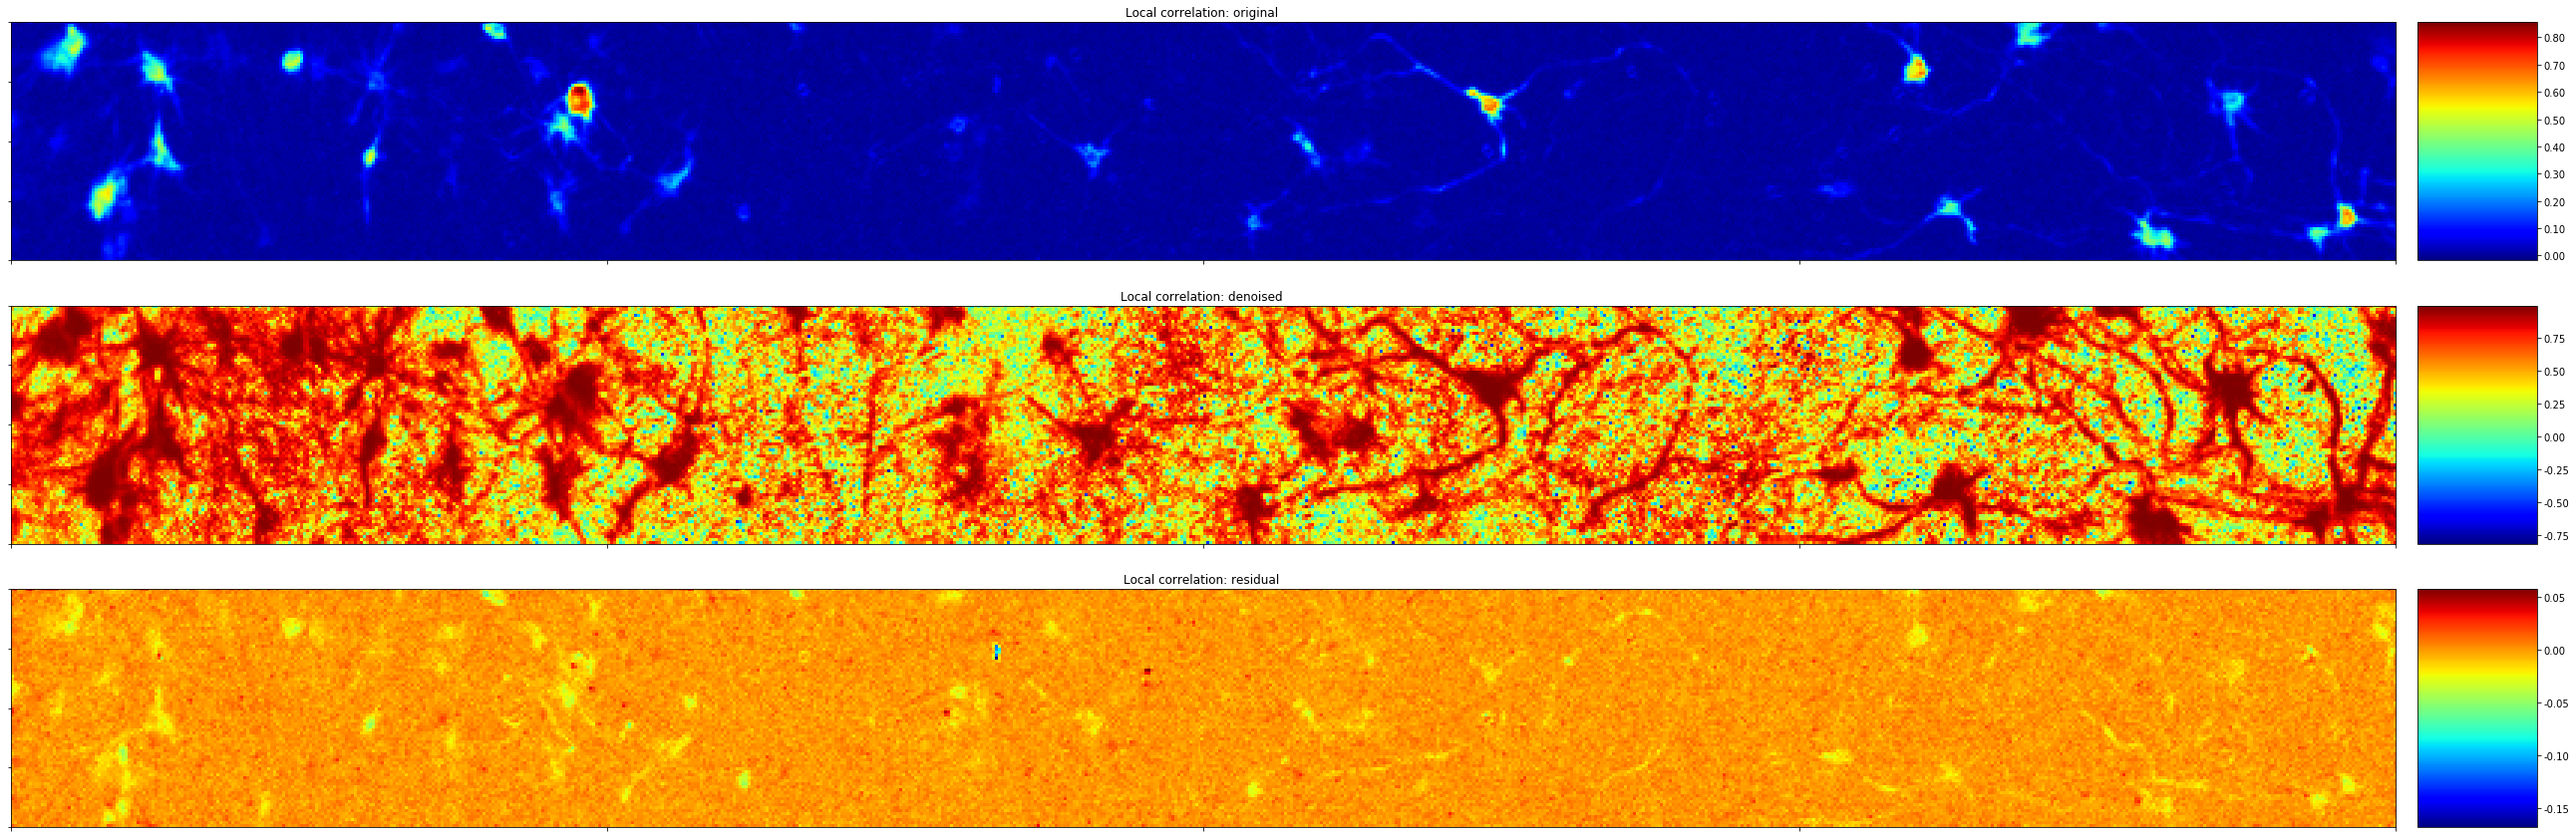

In [21]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

## Generate Paper Figs

Frame:  range [-3.3e+00 3.8e+00]
Frame:  range [-5.9e-01 1.3e+00]
Frame:  range [-3.2e+00 3.6e+00]
SNR:  range [1.1e+00 2.2e+00]
SNR:  range [1.4e+00 8.9e+00]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [-1.5e-02 6.7e-01]
Local correlation:  range [-5.0e-02 2.2e-02]


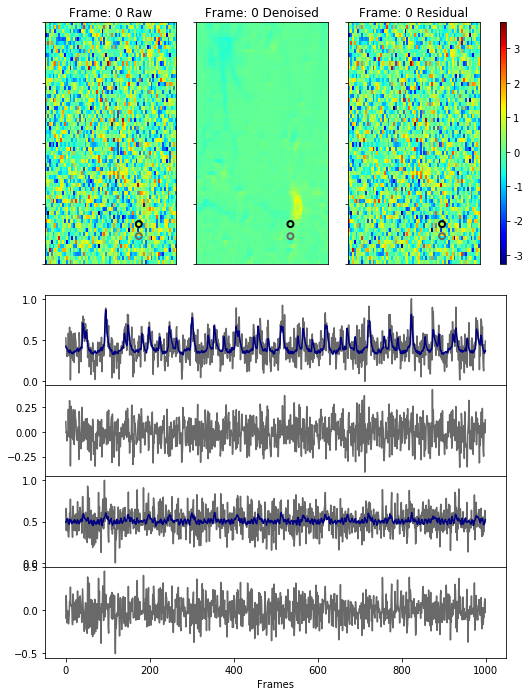

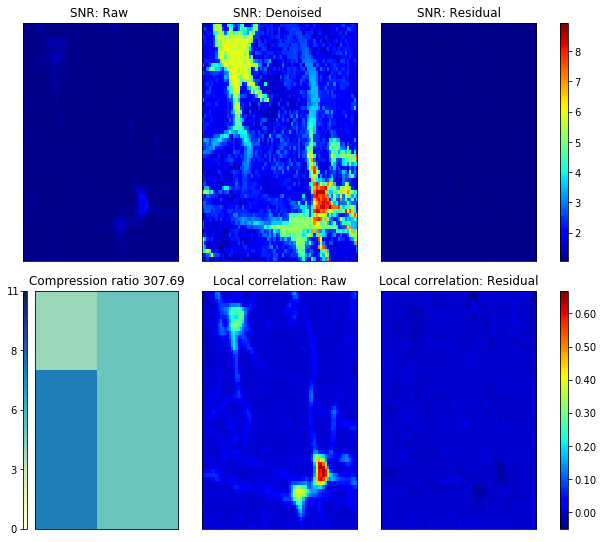

In [22]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks[0],
                    pixel_coor1=[70, 780],
                    pixel_coor2=[73, 780],
                    frame_idx=4500,
                    trace_seg=[4500,5500],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='QState_gPCA.pdf')
plt.show()

## Write Video

In [23]:
#write_video(np.vstack([mov, mov_denoised, mov - mov_denoised]),
#            "gPCA - QState Voltage Imaging",
#            "QState_gPCA.mp4")
#plt.show()
np.savez(os.path.join(ext, "data", "QState_gPCA.npz"), mov, mov_denoised)

# Widefield

In [24]:
dataset = "Widefield"
filename = os.path.join(ext, "data", "hillman_stim1.npz")
block_height = 64
block_width = 64

In [25]:
mov = np.load(filename)['data'].astype(np.float64)[:,:,:-1].copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [26]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

/home/ian/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ian/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Run Decomposition

In [27]:
# Perform 4x Overlapping Blockwise gPCA In Parallel
mov_denoised, block_ranks = temporal(
    mov.copy(), dx=dx, nblocks=[int(fov_height/block_height),
                                int(fov_width/block_width)])

Running 64 blocks in 10 cpus
Blocks(=64) run time: 14.256685
Running 56 blocks in 10 cpus
Blocks(=56) run time: 13.904281
Running 56 blocks in 10 cpus
Blocks(=56) run time: 15.706358
Running 49 blocks in 10 cpus
Blocks(=49) run time: 14.465207


## Run Timing Evaluation

In [28]:
def time_gPCA():
    gpca_denoised, gpca_ranks = temporal(mov,
                                         dx=1,
                                         nblocks=[int(fov_height/block_height),
                                                  int(fov_width/block_width)])

timeit.timeit(time_gPCA, number=5)/5

Running 64 blocks in 10 cpus
Blocks(=64) run time: 14.033630
Running 64 blocks in 10 cpus
Blocks(=64) run time: 13.845493
Running 64 blocks in 10 cpus
Blocks(=64) run time: 13.835730
Running 64 blocks in 10 cpus
Blocks(=64) run time: 13.783931
Running 64 blocks in 10 cpus
Blocks(=64) run time: 13.968244


16.740064103598705

## Produce Performance Diagnostics

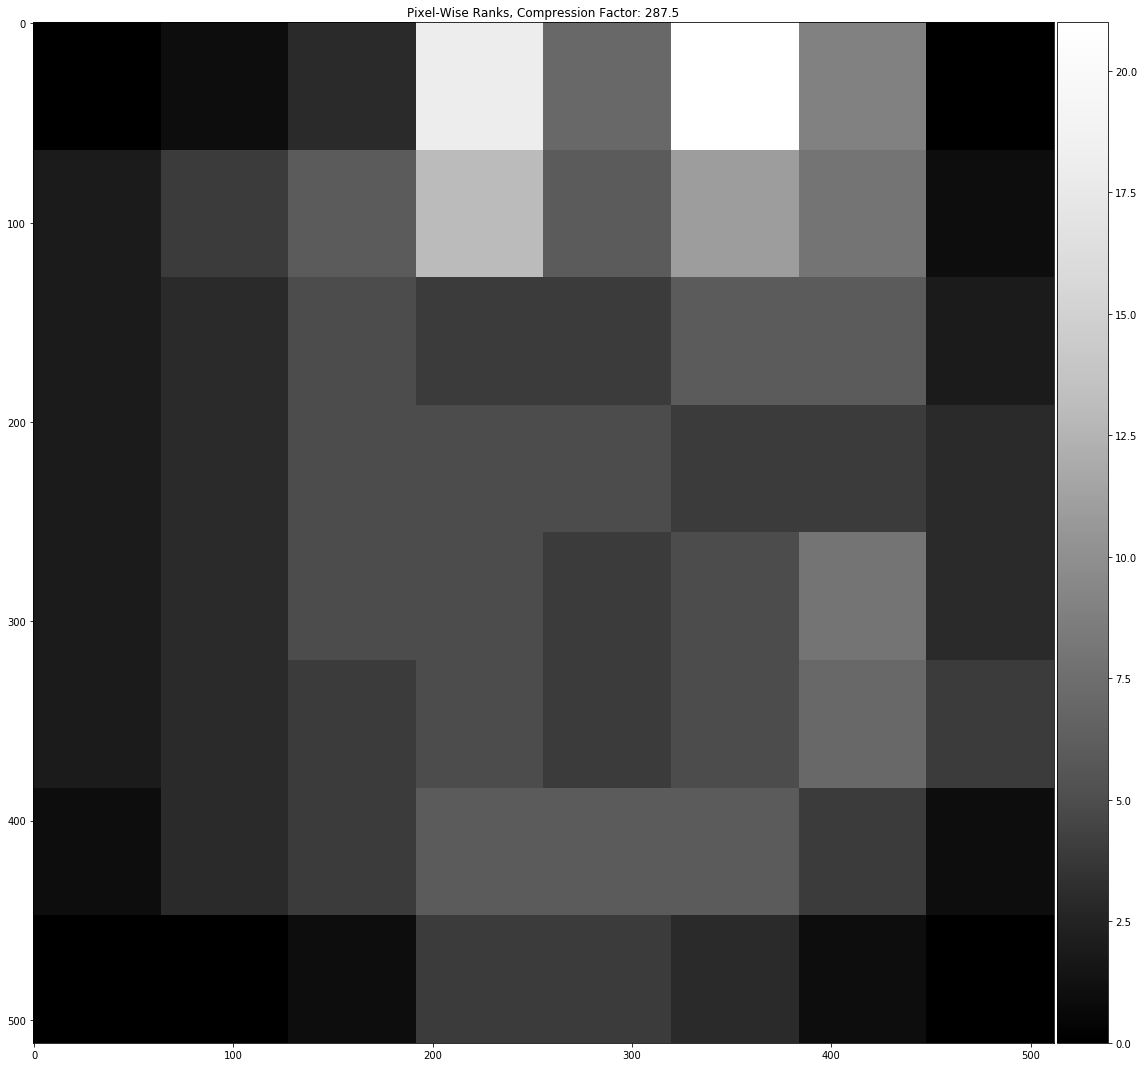

In [29]:
pixelwise_ranks(block_ranks[0], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [-3.4e-02 8.8e-01]
Local correlation:  range [-1.7e-01 1.0e+00]
Local correlation:  range [-8.9e-02 9.2e-02]


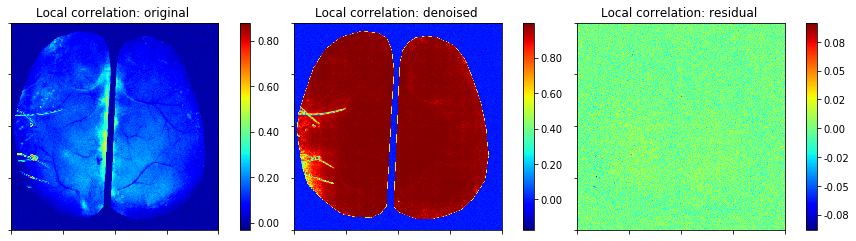

In [30]:
comparison_plot([mov + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01,
                 mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01], plot_orientation="vertical")

## Generate Paper Figs

Frame:  range [-3.4e+00 4.2e+00]
Frame:  range [-2.3e-01 2.8e-01]
Frame:  range [-3.4e+00 4.0e+00]
SNR:  range [1.1e+00 1.5e+00]
SNR:  range [2.2e+00 7.1e+00]
SNR:  range [1.1e+00 1.4e+00]
Local correlation:  range [1.8e-02 2.1e-01]
Local correlation:  range [-3.3e-02 3.3e-02]


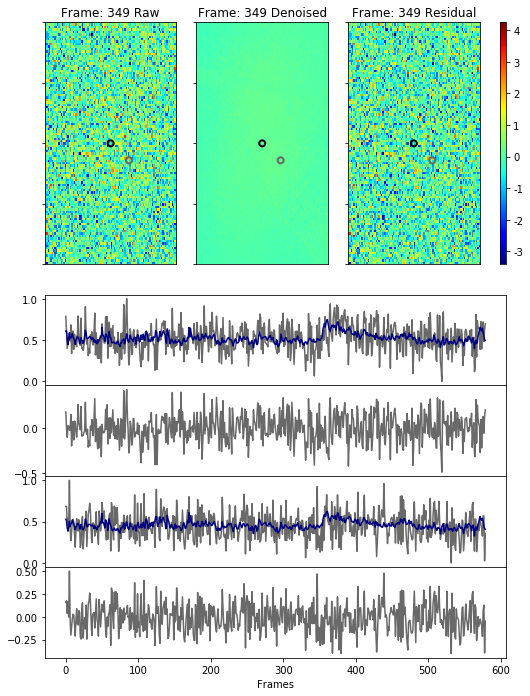

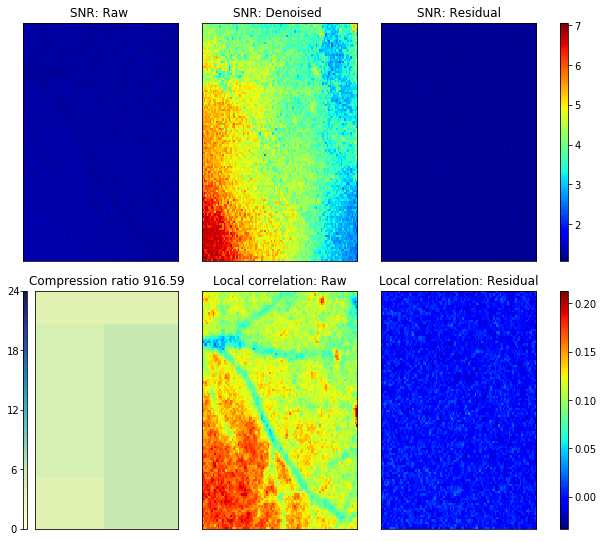

In [31]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks[0],
                    pixel_coor1=[228, 386],
                    pixel_coor2=[235, 400],
                    frame_idx=569,
                    trace_seg=[220,800],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Widefield_gPCA.pdf')
plt.show()

## Write Video

In [32]:
#write_video(np.hstack([mov, mov_denoised, mov - mov_denoised]),
#            "gPCA - Widefield",
#           "Widefield_gPCA.mp4")
#plt.show()
np.savez(os.path.join(ext, "data", "Widefield_gPCA.npz"), mov, mov_denoised)

# Endoscope

In [33]:
# Set Data Information
dataset = "Endoscope"
filename = os.path.join(ext, "data", "pc_blood_vessel_10Hz.npz")
block_height = 16
block_width = 16

In [34]:
mov = np.load(filename)['data'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width
data = np.load("endoscope_prepared.npz")
mov = data['arr_0']
background = data['arr_1']
foreground = data['arr_2']

## Run Decomposition

In [35]:
# Perform 4x Overlapping Blockwise gPCA In Parallel
denoised_foreground, block_ranks = temporal(
    foreground.copy(), dx=1, nblocks=[int(fov_height/block_height),
                                      int(fov_width/block_width)])

Running 256 blocks in 10 cpus
Blocks(=256) run time: 26.996646


## Run Timing Evaluation

In [36]:
def time_gPCA():
    gpca_denoised, gpca_ranks = temporal(foreground,
                                         dx=1,
                                         nblocks=[int(fov_height/block_height),
                                                  int(fov_width/block_width)])

timeit.timeit(time_gPCA, number=5)/5

Running 256 blocks in 10 cpus
Blocks(=256) run time: 27.862247
Running 256 blocks in 10 cpus
Blocks(=256) run time: 27.674461
Running 256 blocks in 10 cpus
Blocks(=256) run time: 27.627008
Running 256 blocks in 10 cpus
Blocks(=256) run time: 28.075315
Running 256 blocks in 10 cpus
Blocks(=256) run time: 27.992499


31.10891931160004

## Produce Performance Diagnostics

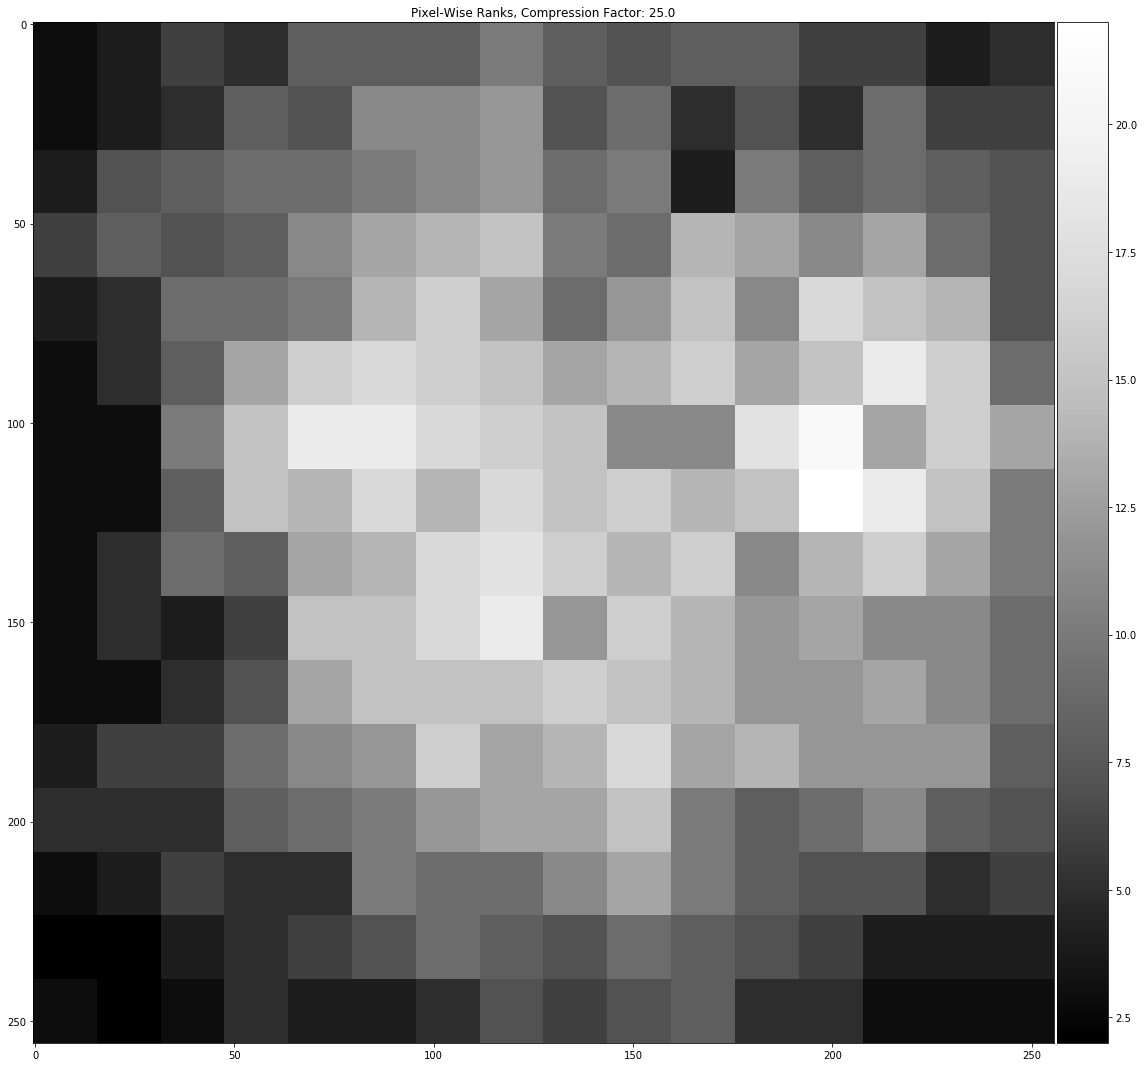

In [37]:
pixelwise_ranks(block_ranks, 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [9.0e-02 9.8e-01]
Local correlation:  range [2.1e-01 1.0e+00]
Local correlation:  range [-1.8e-01 2.9e-01]


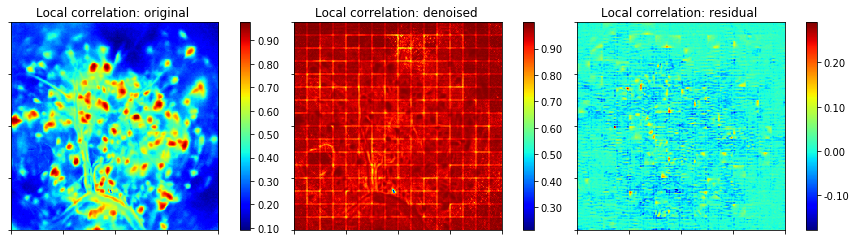

In [38]:
comparison_plot([foreground, denoised_foreground], plot_orientation="vertical")

## Generate Paper Figs

Frame:  range [-4.3e+00 1.0e+01]
Frame:  range [-3.9e+00 9.0e+00]
Frame:  range [-2.8e+00 4.4e+00]
SNR:  range [1.2e+00 7.6e+00]
SNR:  range [1.8e+00 1.2e+01]
SNR:  range [1.1e+00 1.5e+00]
Local correlation:  range [1.0e-01 9.8e-01]
Local correlation:  range [-8.9e-02 2.4e-01]


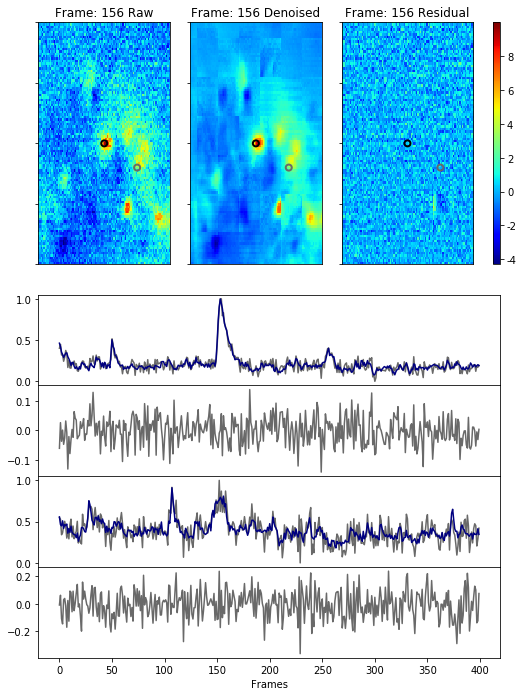

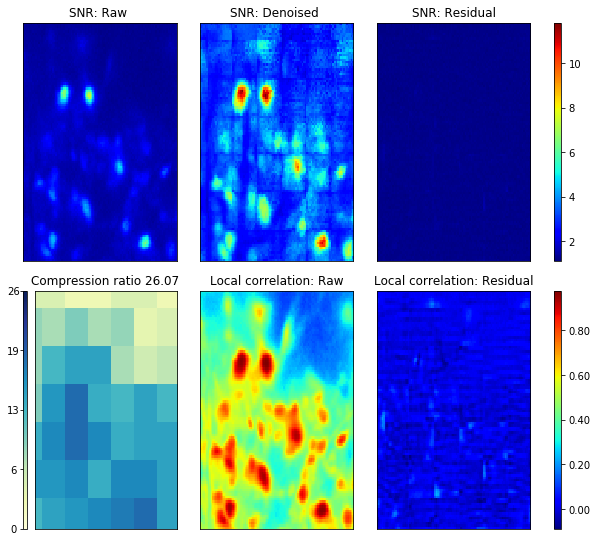

In [39]:
mpdf_plot.pdf_write(foreground,
                    denoised_foreground,
                    ranks=block_ranks,
                    pixel_coor1=[75, 125],
                    pixel_coor2=[85, 150],
                    frame_idx=756,
                    trace_seg=[600,1000],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Endoscope_gPCA.pdf')
plt.show()

## Write Video

In [40]:
#write_video(np.hstack([foreground, denoised_foreground, foreground - denoised_foreground]),
#            "gPCA - Endoscope",
#            "Endoscope_gPCA.mp4")
#plt.show()
np.savez(os.path.join(ext, "data", "Endoscope_gPCA.npz"), foreground, denoised_foreground)

In [41]:
del foreground, denoised_foreground, data, background

# Dendritic

In [42]:
dataset = "Dendritic"
filename = os.path.join(ext, "data", "xp33_60pct_210_192_-1000_rig.npy")
block_height = 42
block_width = 24
d_sub = 1

In [43]:
mov = np.load(filename).astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [44]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

## Run Decomposition

In [45]:
# Perform 4x Overlapping Blockwise gPCA In Parallel
mov_denoised, block_ranks = temporal(mov.copy(), dx=dx,
                                     nblocks=[int(fov_height/block_height),
                                              int(fov_width/block_width)])

Running 40 blocks in 10 cpus
Blocks(=40) run time: 3.964976
Running 32 blocks in 10 cpus
Blocks(=32) run time: 3.624030
Running 35 blocks in 10 cpus
Blocks(=35) run time: 3.641747
Running 28 blocks in 10 cpus
Blocks(=28) run time: 3.595473


## Run Timing Evaluation

In [46]:
def time_gPCA():
    gpca_denoised, gpca_ranks = temporal(mov, dx=1, nblocks=[int(fov_height/block_height),
                                                             int(fov_width/block_width)])

timeit.timeit(time_gPCA, number=1)/1

Running 40 blocks in 10 cpus
Blocks(=40) run time: 2.509605


3.005060447991127

## Produce Performance Diagnostics

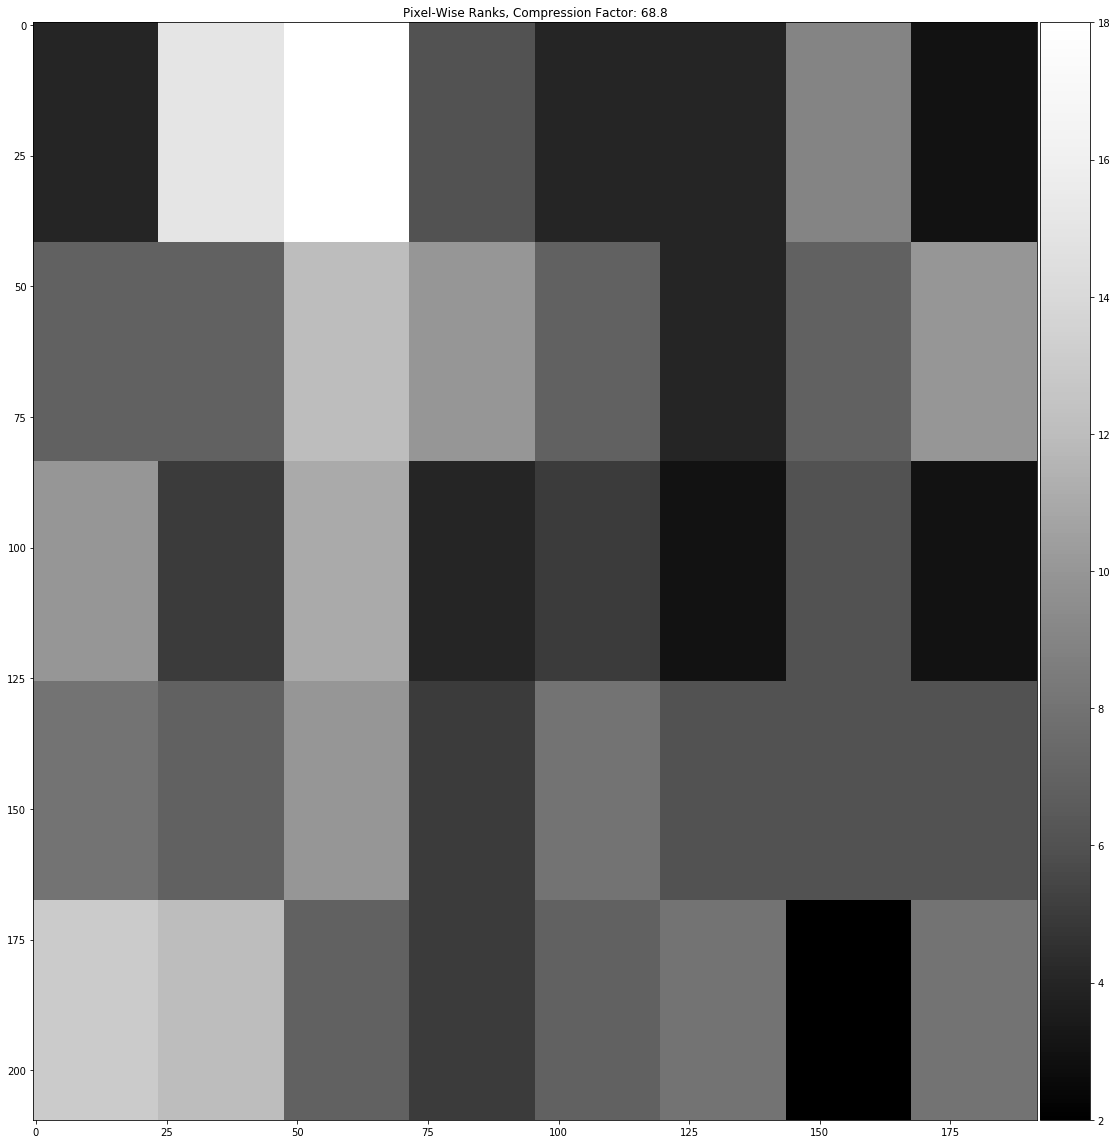

In [47]:
pixelwise_ranks(block_ranks[0], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [-3.6e-02 9.0e-01]
Local correlation:  range [-6.9e-01 9.9e-01]
Local correlation:  range [-1.3e-01 1.2e-01]


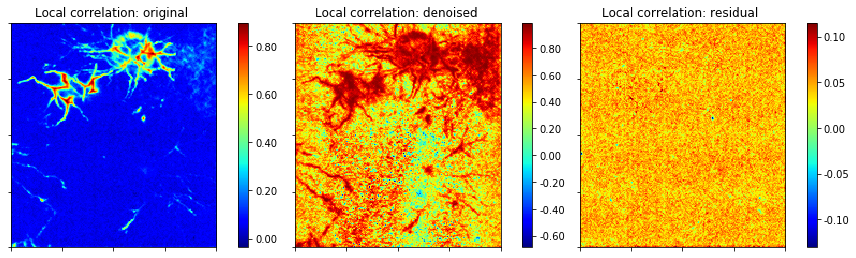

In [48]:
comparison_plot([mov, mov_denoised], plot_orientation="vertical")

## Generate Paper Figs

Frame:  range [-1.7e+00 2.3e+01]
Frame:  range [-1.0e+00 2.0e+01]
Frame:  range [-4.9e+00 6.6e+00]
SNR:  range [1.1e+00 5.7e+00]
SNR:  range [1.2e+00 1.6e+01]
SNR:  range [1.0e+00 1.4e+00]
Local correlation:  range [1.9e-02 9.0e-01]
Local correlation:  range [-9.4e-02 1.2e-01]


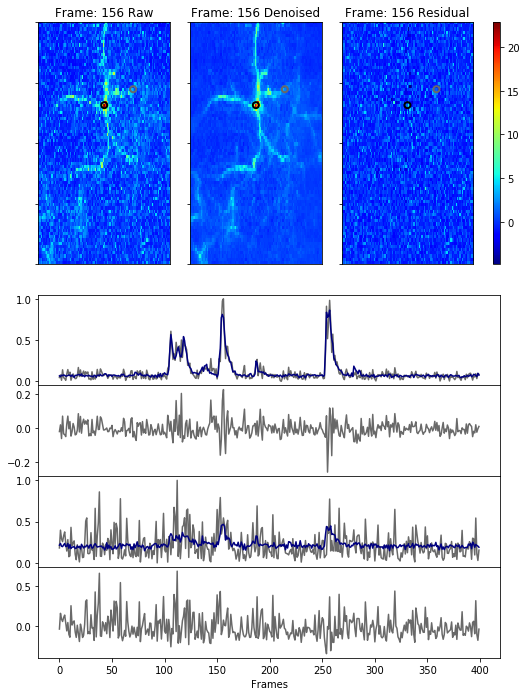

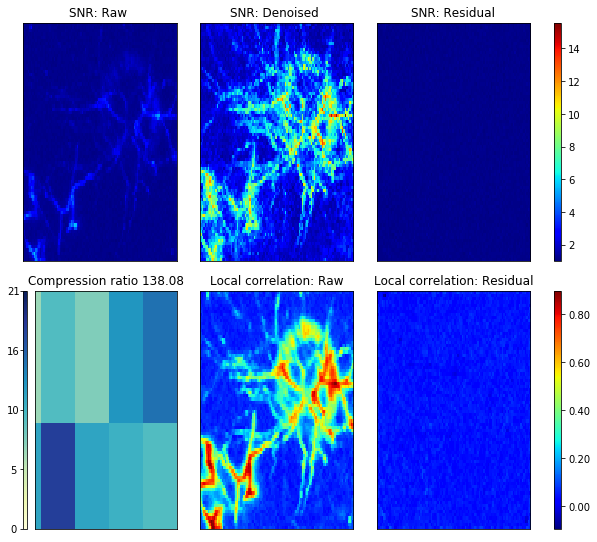

In [49]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks[0],
                    pixel_coor1=[26, 94],
                    pixel_coor2=[21, 116],
                    frame_idx=756,
                    trace_seg=[600,1000],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Dendritic_gPCA.pdf')
plt.show()

## Write Video

In [50]:
#write_video(np.hstack([mov, mov_denoised, mov - mov_denoised]),
#            "gPCA - Dendritic",
#            "Dendritic_gPCA.mp4")
#plt.show()
np.savez(os.path.join(ext, "data", "Dendritic_gPCA.npz"), mov, mov_denoised)